In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR

In [2]:
origin_raw_data_dir = 'C:\\Users\\a1882\Desktop\EEG\open\\NN\dataset\\128_s100'
model_save ='C:\\Users\\a1882\\Desktop\\EEG\\normal\\model'
pic_dir = 'C:\\Users\\a1882\\Desktop\\EEG\\normal\\pic'

In [3]:
class EEG_Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = origin_raw_data_dir
        self.file_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        data = pd.read_csv(file_path, header=None)
        data = data.values
        data = torch.from_numpy(data)
        label_map = {'lefthand': 0, 'read': 1, 'rest': 2, 'walkbase': 3, 'walkl': 4 ,'walkfocus': 5}
        data_label = label_map[file_name.split('_')[0]]
        return data, data_label

In [4]:
dataset = EEG_Dataset(origin_raw_data_dir)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=False)

In [6]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 4), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(1024, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        print('x:', x.shape)
        x = self.conv1(x)
        print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        print('pool1:', x.shape)
        x = self.dropout1(x)
        x = self.conv2(x)
        print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        print('pool2:', x.shape)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        print('flatten:', x.shape)
        x = self.fc1(x)
        print('fc1:', x.shape)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        print('fc2:', x.shape)
        return x

In [7]:
X = torch.randn(size=( 1, 32, 128), dtype=torch.float32)
model = EEGNet()
output = model(X)
print(output.shape)

x: torch.Size([1, 1, 32, 128])
conv1: torch.Size([1, 16, 32, 63])
pool1: torch.Size([1, 16, 32, 15])
conv2: torch.Size([1, 32, 32, 7])
pool2: torch.Size([1, 32, 32, 1])
flatten: torch.Size([1, 1024])
fc1: torch.Size([1, 128])
fc2: torch.Size([1, 6])
torch.Size([1, 6])


In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
learning_rate = 0.001
num_epochs = 200
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            global train_loss
            train_loss.append(loss)



def test(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    global valid_loss
    valid_loss.append(test_loss)
    global accuracy
    accuracy.append(correct)

In [10]:
#torch.cuda.empty_cache()
#model = model.cuda()
train_loss = []
valid_loss = []
accuracy = []
for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    model.train(True)
    train(train_loader, model, loss_fn, optimizer)

    model.train(False)
    test(test_loader, model, loss_fn)

    if t > num_epochs-5:
        torch.save(model.state_dict(), os.path.join(model_save,'cnn_128_100e_'+str(t)+'.pt'))

print("Done!")

Epoch 1
-------------------------------
loss: 1.797559  [    0/ 3788]
Test Error:
 Accuracy: 25.1%, Avg loss: 1.671532 

Epoch 2
-------------------------------
loss: 1.609870  [    0/ 3788]
Test Error:
 Accuracy: 25.4%, Avg loss: 1.618400 

Epoch 3
-------------------------------
loss: 1.518554  [    0/ 3788]
Test Error:
 Accuracy: 32.4%, Avg loss: 1.576082 

Epoch 4
-------------------------------
loss: 1.420602  [    0/ 3788]
Test Error:
 Accuracy: 49.3%, Avg loss: 1.529740 

Epoch 5
-------------------------------
loss: 1.336463  [    0/ 3788]
Test Error:
 Accuracy: 55.8%, Avg loss: 1.479656 

Epoch 6
-------------------------------
loss: 1.244465  [    0/ 3788]
Test Error:
 Accuracy: 59.0%, Avg loss: 1.429071 

Epoch 7
-------------------------------
loss: 1.170379  [    0/ 3788]
Test Error:
 Accuracy: 61.5%, Avg loss: 1.376812 

Epoch 8
-------------------------------
loss: 1.122537  [    0/ 3788]
Test Error:
 Accuracy: 64.4%, Avg loss: 1.326168 

Epoch 9
------------------------

Done!


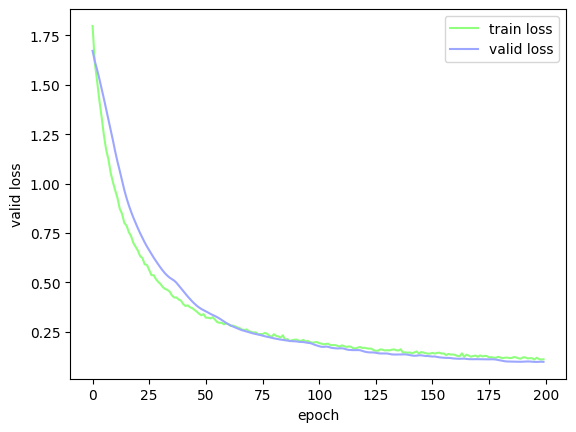

In [11]:
print("Done!")
import matplotlib.pyplot as plt
%matplotlib inline
hex_d1 = '#91FF7E'
hex_d2 = '#9DA7FF'

plt.figure()
plt.plot(train_loss, hex_d1, label='train loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.plot(valid_loss, hex_d2, label='valid loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend()

plt.savefig(os.path.join(pic_dir, 'conv2_cnn_128_s100_loss.png'))
plt.show()

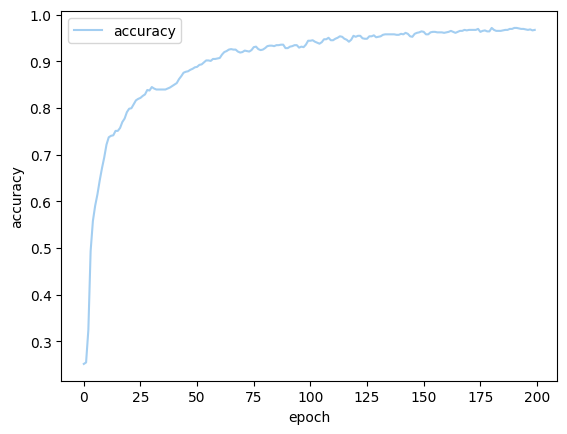

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(accuracy, color = '#A3CEF1', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(pic_dir, 'conv2_cnn_128_s100_acc.png'))
plt.show()